# Introduction

This notebook demonstrates how to perform phase and electrochemical assessments starting from a VASP calculation using Python Materials Genomics (pymatgen) and the Materials Project database (via the Materials API). These notebooks are described in detail in

    Deng, Z.; Zhu, Z.; Chu, I.-H.; Ong, S. P. Data-Driven First-Principles Methods for the Study and Design of 
    Alkali Superionic Conductors. Chem. Mater. 2017, 29 (1), 281–288 DOI: 10.1021/acs.chemmater.6b02648.
    
If you find these notebooks useful and use the functionality demonstrated, please consider citing the above work.

Let's start by importing some modules and classes that we will be using.

In [1]:
%matplotlib inline

from pymatgen.core import Composition, Element
from pymatgen.ext.matproj import MPRester
from pymatgen.io.vasp import Vasprun
from pymatgen.phasediagram.maker import PhaseDiagram, CompoundPhaseDiagram
from pymatgen.phasediagram.analyzer import PDAnalyzer
from pymatgen.phasediagram.plotter import PDPlotter
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen.entries.compatibility import MaterialsProjectCompatibility
from pymatgen.util.plotting_utils import get_publication_quality_plot
import json
import re
import palettable
import matplotlib as mpl

# Preparation

We will first read the results from the *vasprun.xml* output file from our VASP calculations. Only the lowest energy result is used here.

In [2]:
vasprun = Vasprun("aimd_data/vasprun.xml.relax2.gz")
# include structure so proper correction can be applied for oxides and sulfides
entry = vasprun.get_computed_entry(inc_structure=True)  

To construct the phase diagram, we need all entries in the Li-P-S-Cl chemical space. We will use the *MPRester* class to obtain these entries from the Materials Project via the Materials API.

In [3]:
rester = MPRester()
mp_entries = rester.get_entries_in_chemsys(["Li", "P", "S", "Cl"])

In addition to all the MP entries, here we also load the computed entries of O/S substituted Li-P-O tenary compounds.

In [4]:
with open("aimd_data/lpo_entries.json") as f:
    lpo_data = json.load(f)
lpo_entries = [ComputedEntry.from_dict(d) for d in lpo_data]

Next, we need to combine all the entries and postprocess them using *MaterialsProjectCompatibility*. This postprocessing step corrects the energies to account for well-known DFT errors, e.g., in the sulfur binding energy.

In [5]:
compatibility = MaterialsProjectCompatibility()
entry = compatibility.process_entry(entry)
entries = compatibility.process_entries([entry] + mp_entries + lpo_entries)

# Phase diagram construction

The phase diagram can then be constructed using the *PhaseDiagram* class, and plotted using the *PDPlotter* class.

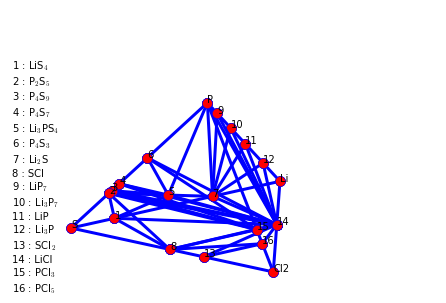

In [6]:
pd = PhaseDiagram(entries)
plotter = PDPlotter(pd)
plotter.show()

We may observe from the above phase diagram that Li6PS5Cl is not a stable phase (red nodes) in the calculated 0K phase diagram.

The pseudo-ternary Li2S-P2S5-LiCl is constructed using the *CompoundPhaseDiagram* class.

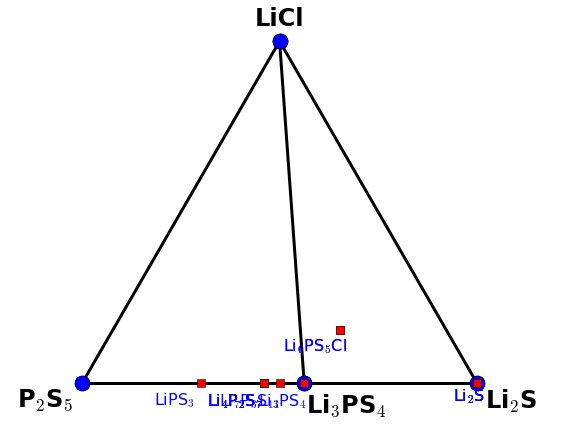

In [7]:
cpd = CompoundPhaseDiagram(entries, 
                           [Composition("P2S5"), Composition("Li2S"), Composition("LiCl")])
cplotter = PDPlotter(cpd, show_unstable=True)
cplotter.show()

# Calculating $E_{\rm hull}$ of Li6PS5Cl

We may evaluate the $E_{\rm hull}$ of Li6PS5Cl using the *PDAnalyzer*.

In [8]:
analyzer = PDAnalyzer(pd)
ehull = analyzer.get_e_above_hull(entry)
print("The energy above hull of Li6PS5Cl is %.3f eV/atom." % ehull)

The energy above hull of Li6PS5Cl is 0.021 eV/atom.


# Electrochemical Stability

The electrochemical stability can be assessed using a similar phase diagram approach, but using the lithium grand potential instead of the internal energy.

First, we need to identify a reference for lithium chemical potential using the bulk Li energy $\mu_{\rm Li}^0$.

In [9]:
li_entries = [e for e in entries if e.composition.reduced_formula == "Li"]
uli0 = min(li_entries, key=lambda e: e.energy_per_atom).energy_per_atom

The *PDAnalyzer* class provides a quick way to plot the phase diagram at a particular composition (e.g., Li6PS5Cl) as a function of lithium chemical potential called *get_element_profile*.

In [10]:
el_profile = analyzer.get_element_profile(Element("Li"), entry.composition)
for i, d in enumerate(el_profile):
    voltage = -(d["chempot"] - uli0)
    print("Voltage: %s V" % voltage)
    print(d["reaction"])
    print("")

Voltage: -0.0 V
4.000 Li6PS5Cl + 32.000 Li -> 4.000 Li3P + 4.000 LiCl + 20.000 Li2S

Voltage: 0.8693499325 V
4.000 Li6PS5Cl + 24.000 Li -> 4.000 LiP + 20.000 Li2S + 4.000 LiCl

Voltage: 0.934797859375 V
4.000 Li6PS5Cl + 21.714 Li -> 0.571 Li3P7 + 20.000 Li2S + 4.000 LiCl

Voltage: 1.16859139812 V
4.000 Li6PS5Cl + 20.571 Li -> 4.000 LiCl + 20.000 Li2S + 0.571 LiP7

Voltage: 1.29794984292 V
4.000 Li6PS5Cl + 20.000 Li -> 4.000 P + 20.000 Li2S + 4.000 LiCl

Voltage: 1.71892977688 V
4.000 Li6PS5Cl -> 0.000 Li + 4.000 Li3PS4 + 4.000 LiCl + 4.000 Li2S

Voltage: 2.14019005929 V
4.000 Li6PS5Cl -> 7.000 Li + 4.000 Li3PS4 + 4.000 LiCl + 1.000 LiS4

Voltage: 2.47188645738 V
4.000 Li6PS5Cl -> 17.500 Li + 4.000 LiCl + 2.000 P2S5 + 2.500 LiS4

Voltage: 2.846213603 V
4.000 Li6PS5Cl -> 22.500 Li + 4.000 SCl + 2.000 P2S5 + 1.500 LiS4

Voltage: 3.74073532125 V
4.000 Li6PS5Cl -> 24.000 Li + 2.000 P2S5 + 6.000 S + 4.000 SCl



This element profile can be plotted as a Li evolution versus voltage using matplotlib as follows.

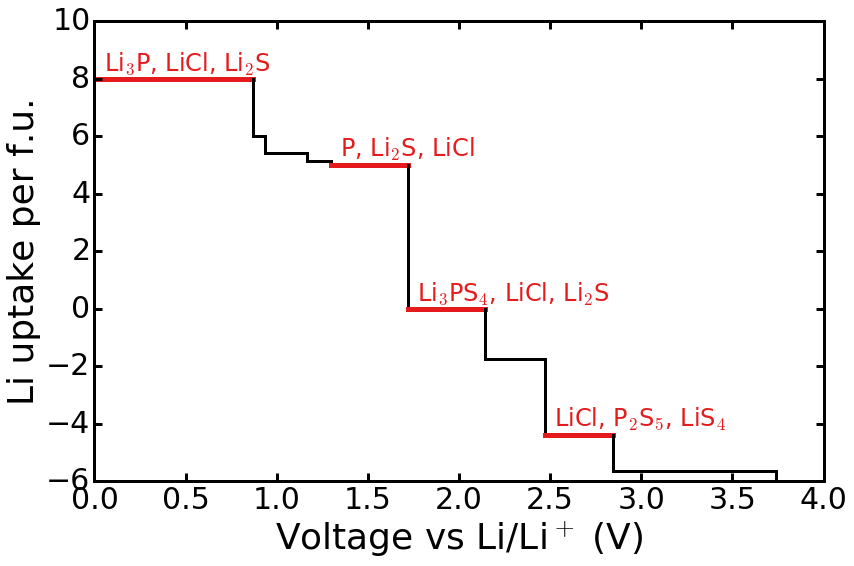

In [11]:
# Some matplotlib settings to improve the look of the plot.
mpl.rcParams['axes.linewidth']=3
mpl.rcParams['lines.markeredgewidth']=4
mpl.rcParams['lines.linewidth']=3
mpl.rcParams['lines.markersize']=15
mpl.rcParams['xtick.major.width']=3
mpl.rcParams['xtick.major.size']=8
mpl.rcParams['xtick.minor.width']=3
mpl.rcParams['xtick.minor.size']=4
mpl.rcParams['ytick.major.width']=3
mpl.rcParams['ytick.major.size']=8
mpl.rcParams['ytick.minor.width']=3
mpl.rcParams['ytick.minor.size']=4


# Plot of Li uptake per formula unit (f.u.) of Li6PS5Cl against voltage vs Li/Li+.

colors = palettable.colorbrewer.qualitative.Set1_9.mpl_colors
plt = get_publication_quality_plot(12, 8)

for i, d in enumerate(el_profile):
    v = - (d["chempot"] - uli0)
    if i != 0:
        plt.plot([x2, x2], [y1, d["evolution"] / 4.0], 'k', linewidth=3)
    x1 = v
    y1 = d["evolution"] / 4.0
    if i != len(el_profile) - 1:
        x2 = - (el_profile[i + 1]["chempot"] - uli0)
    else:
        x2 = 5.0
        
    if i in [0, 4, 5, 7]:
        products = [re.sub(r"(\d+)", r"$_{\1}$", p.reduced_formula)                     
                    for p in d["reaction"].products if p.reduced_formula != "Li"]

        plt.annotate(", ".join(products), xy=(v + 0.05, y1 + 0.3), 
                     fontsize=24, color=colors[0])
        
        plt.plot([x1, x2], [y1, y1], color=colors[0], linewidth=5)
    else:
        plt.plot([x1, x2], [y1, y1], 'k', linewidth=3)  

plt.xlim((0, 4.0))
plt.ylim((-6, 10))
plt.xlabel("Voltage vs Li/Li$^+$ (V)")
plt.ylabel("Li uptake per f.u.")
plt.tight_layout()